In [1]:
!pip install recogym
!pip install seaborn

# Optimizer's curse

We will use the same likelihood model built in the previous notebook to showcase the optimizer's curse and how that can even lead to an inversion of arms (making a wrong decision).

Let's first setup, as usual, the environment.

In [2]:
from recogym.envs.session import OrganicSessions

from numpy.random.mtrand import RandomState
from recogym import Configuration
from recogym.agents import Agent
from sklearn.linear_model import LogisticRegression
from recogym import verify_agents
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.evaluate_agent import verify_agents, plot_verify_agents

import gym, recogym
from copy import deepcopy
from recogym import env_1_args
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

num_users = 5000
num_products = 10

env_1_args['random_seed'] = 42
env_1_args['num_products'] = num_products

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

We will use a logging policy that shows products with a probability proportional to their popularity (very plausible world model).

In [3]:
NUM_USERS = 1000
NUM_PRODUCTS = 10

organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
           **organic_user_count_args,
           **env_1_args,
           'select_randomly': True,
       }))

popularity_policy_logs = env.generate_logs(NUM_USERS, organic_counter_agent)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 1000/1000 [00:27<00:00, 36.55it/s]


Again we use our product views feature provider.

In [4]:
from recogym.agents import FeatureProvider

class CountFeatureProvider(FeatureProvider):
    """Feature provider as an abstract class that defined interface of setting/getting features"""

    def __init__(self, config):
        super(CountFeatureProvider, self).__init__(config)
        self.feature_data = np.zeros((self.config.num_products))

    def observe(self, observation):
        """Consider an Organic Event for a particular user"""
        for session in observation.sessions():
            self.feature_data[int(session['v'])] += 1

    def features(self, observation):
        """Provide feature values adjusted to a particular feature set"""
        return self.feature_data

    def reset(self):
        self.feature_data = np.zeros((self.config.num_products))

In [5]:
import math
import numpy as np
from recogym import Configuration, DefaultContext, Observation


def build_train_data(logs, feature_provider):
    user_states, actions, rewards, proba_actions = [], [], [], []

    current_user = None
    for _, row in logs.iterrows():
        if current_user != row['u']:
            # Use has changed: start a new session and reset user state
            current_user = row['u']
            sessions = OrganicSessions()
            feature_provider.reset()

        context = DefaultContext(row['u'], row['t'])

        if row['z'] == 'organic':
            sessions.next(context, row['v'])

        else:
            # For each bandit event, generate one observation for the user state,
            # the taken action the obtained reward and the used probabilities
            feature_provider.observe(Observation(context, sessions))
            user_states.append(feature_provider.features(None))
            actions.append(row['a'])
            rewards.append(row['c'])
            proba_actions.append(row['ps'])

            # Start a new organic session
            sessions = OrganicSessions()

    return np.array(user_states), np.array(actions).astype(int), np.array(rewards), np.array(proba_actions)

In [6]:
# You can now see data that will be provided to our agents based on logistic regressions.
config = Configuration(env_1_args)
count_feature_provider = CountFeatureProvider(config=config)

user_states, actions, rewards, proba_actions = build_train_data(popularity_policy_logs, count_feature_provider)

In [7]:
preview_start, preview_size = 500, 3

print('user product views count at action time')
print(user_states[preview_start:preview_start + preview_size])
print('taken actions', actions[preview_start:preview_start + preview_size])
print('obtained rewards', rewards[preview_start:preview_start + preview_size])
print('probablities of the taken actions', proba_actions[preview_start:preview_start + preview_size])

user product views count at action time
[[ 7.  1.  0.  1.  5. 14.  0.  0.  0.  0.]
 [ 7.  1.  0.  1.  5. 14.  0.  0.  0.  0.]
 [ 7.  1.  0.  1.  5. 14.  0.  0.  0.  0.]]
taken actions [5 5 5]
obtained rewards [0. 0. 0.]
probablities of the taken actions [0.71428571 0.71428571 0.71428571]


In [8]:
class LikelihoodAgent(Agent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        self.feature_provider = feature_provider
        self.use_argmax = use_argmax
        self.random_state = RandomState(seed)
        self.model = None
        
    @property
    def num_products(self):
        return self.feature_provider.config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state"""
        features = np.zeros(len(user_state) * self.num_products)
        features[action * len(user_state): (action + 1) * len(user_state)] = user_state
        
        return features
    
    def train(self, logs):
        user_states, actions, rewards, proba_actions = build_train_data(logs, self.feature_provider)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)
    
    def _score_products(self, user_state):
        all_action_features = np.array([
            self._create_features(user_state, action) 
            for action in range(self.num_products)
        ])
        return self.model.predict_proba(all_action_features)[:, 1]
        
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        self.feature_provider.observe(observation)        
        user_state = self.feature_provider.features(observation)
        prob = self._score_products(user_state)
        
        if not self.use_argmax:
            action = self.random_state.choice(self.num_products, p=(prob / np.sum(prob)))
            ps = prob[action]
            all_ps = prob.copy()
        else:
            action = np.argmax(prob)
            ps = 1.0
            all_ps = np.zeros(self.num_products)
            all_ps[action] = 1.0
      
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'expected-value': prob[action],
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        self.feature_provider.reset()  

In [9]:
def run_agent(env, num_users, agent):
    """Small utility function to collect stats about your agent on simulated test traffic
    It is really recogym specific, you do not need to look at its internal details
    """
    env = deepcopy(env)
    env.agent = agent  
    
    events = []
    for user_id in range(num_users):
        env.reset(user_id)
        observation, reward, done, _ = env.step(None)

        while not done:
            for session in observation.sessions():
                events += [{**session, 'z': 'organic'}]

            action, observation, reward, done, info = env.step_offline(observation, reward, done)
            events += [{**action, 'z': 'bandit', 'c': reward}]

            if done:
                break

    events_df = pd.DataFrame().from_dict(events)
    ordered_cols = ['t', 'u', 'z', 'v', 'a', 'c', 'ps', 'ps-a']
    all_cols = ordered_cols + [col for col in events_df.columns if col not in ordered_cols]
    return events_df[all_cols]

In [14]:
# Have a look at the feature vector used by the Likelihood agent.
picked_sample = 500

count_product_views_feature_provider = CountFeatureProvider(config)
likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)

print('User state: ', user_states[picked_sample])
print('Action: ', actions[picked_sample])
print('Created cross features: ')
print(likelihood_logreg._create_features(user_states[picked_sample], actions[picked_sample]))

User state:  [ 7.  1.  0.  1.  5. 14.  0.  0.  0.  0.]
Action:  5
Created cross features: 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  1.  0.  1.
  5. 14.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [11]:
%%time

likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider, use_argmax=True)
likelihood_logreg.train(popularity_policy_logs)

CPU times: user 38.5 s, sys: 852 ms, total: 39.4 s
Wall time: 32 s


In [12]:
n_test_users = 1000
likelihood_logreg_test_logs = run_agent(env, n_test_users, likelihood_logreg)

## Looking at the predicted number of clicks vs. the actual number

We can see that the model over-predicted the number of clicks, and even inversed the order of products 3 and 4.

Text(0.5, 0, 'Selected product')

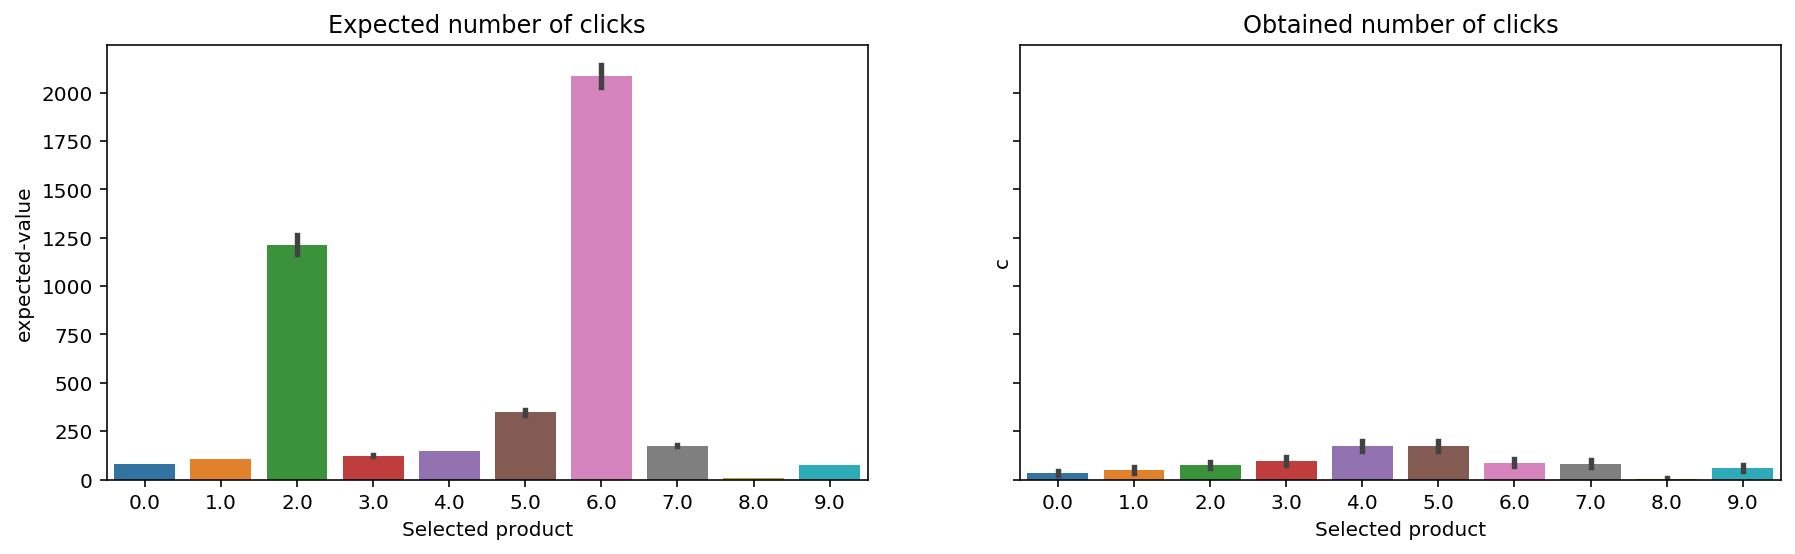

In [13]:
import seaborn as sns

# To force the arms to share the same colors
palette = {c: f'C{c}' for c in range(NUM_PRODUCTS)} if NUM_PRODUCTS < 20 else None

fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
sns.barplot(x="a", y="expected-value", data=likelihood_logreg_test_logs, ax=axes[0], estimator=sum, palette=palette)
axes[0].set_title('Expected number of clicks')
axes[0].set_xlabel('Selected product')

sns.barplot(x="a", y="c", data=likelihood_logreg_test_logs, ax=axes[1], estimator=sum, palette=palette)
axes[1].set_title('Obtained number of clicks')
axes[1].set_xlabel('Selected product')